**Задание**: провести разведочный анализ данных, придумать продуктовые и технические гипотезы — какую ценность можете извлечь из данных для организации, которая предоставила данные.

# Общее описание `transaction_fraud_data.parquet`

Этот анонимизированный набор данных реальных финансовые транзакции, который предназначен для разработки и тестирования моделей выявления мошеннических операций.

Он охватывает различные сценарии — от розничной торговли и ресторанов до путешествий и здравоохранения — и включает как легитимные, так и мошеннические операции. В нём представлены важные признаки, влияющие на распознавание мошенничества: сумма, тип устройства, география, валюта, тип карты и метка `is_fraud`.

## Ключевые особенности

- **Разнообразие категорий**: Розница (онлайн и офлайн), рестораны (фастфуд и премиум), развлечения, здравоохранение, образование, топливо, путешествия и др.
- **География и валюта**: Транзакции охватывают разные страны, города и валюты, что позволяет моделировать глобальные риски.
- **Профили клиентов**: Для каждой транзакции предусмотрены данные о клиенте — возраст аккаунта, используемые устройства, типичные траты, уровень защиты от мошенничества.
- **Данные, готовые для ML**: Признаки включают скорость транзакций, риск вендора, присутствие карты, отпечатки устройств и другие факторы, помогающие обнаруживать подозрительные паттерны.

## Возможные применения

- Построение моделей выявления мошенничества.
- Анализ транзакционного поведения клиентов.
- Разработка и тестирование алгоритмов обнаружения аномалий.
- Изучение методов feature engineering, оценки моделей и оптимизации производительности в сфере финтеха и e-commerce.


# Содержание файла `transaction_fraud_data.parquet`

| Поле | Описание | Тип |
|------|----------|-----|
| `transaction_id` | Уникальный идентификатор транзакции | String |
| `customer_id` | Уникальный идентификатор клиента | String |
| `card_number` | Маскированный номер карты | Int64 |
| `timestamp` | Дата и время транзакции | Datetime(time_unit='us') |
| `vendor_category` | Общая категория вендора (например, Розница, Путешествия) | String |
| `vendor_type` | Тип вендора внутри категории (например, "онлайн") | String |
| `vendor` | Название вендора | String |
| `amount` | Сумма транзакции | Float64 |
| `currency` | Валюта (например, USD, EUR, JPY) | String |
| `country` | Страна, где проведена транзакция | String |
| `city` | Город, где проведена транзакция | String |
| `city_size` | Размер города (например, средний, крупный) | String |
| `card_type` | Тип карты (например, Basic Credit, Gold Credit) | String |
| `is_card_present` | Присутствовала ли карта физически при оплате (POS) | Boolean |
| `device` | Устройство, с которого проведена транзакция (например, Chrome, iOS App) | String |
| `channel` | Канал проведения транзакции (веб, мобильный, POS) | String |
| `device_fingerprint` | Уникальный отпечаток устройства | String |
| `ip_address` | IP-адрес транзакции | String |
| `is_outside_home_country` | Признак того, что операция проведена вне страны клиента | Boolean |
| `is_high_risk_vendor` | Является ли категория вендора рискованной (например, Путешествия, Развлечения) | Boolean |
| `is_weekend` | Произошла ли операция в выходной день | Boolean |
| `last_hour_activity` | Показатели активности за последний час в виде вложенной структуры | Struct({'num_transactions': Int64, 'total_amount': Float64, 'unique_merchants': Int64, 'unique_countries': Int64, 'max_single_amount': Float64}) |
| `is_fraud` | Является ли транзакция мошеннической (`True` / `False`) | Boolean |

Составное поле `last_hour_activity`:

| Ключ | Описание | Тип |
|------|----------|-----|
| `num_transactions` | Количество транзакций | Int64 |
| `total_amount` | Общая сумма транзакций | Float64 |
| `unique_merchants` | Число уникальных продавцов | Int64 |
| `unique_countries` | Число уникальных стран | Int64 |
| `max_single_amount` | Максимальная сумма одной транзакции | Float64 |


# Содержание файла `historical_currency_exchange.parquet`

Вспомогательные данные для перевода операций в нужную валюту.

Обменный курс с `2024-09-30` по `2024-10-30` относительно `USD`.

| Поле | Описание | Тип |
|------|----------|-----|
| `date` | Дата обменного курса | Date |
| `AUD` | Австралийский доллар | Float64 |
| `BRL` | Бразильский реал | Float64 |
| `CAD` | Канадский доллар | Float64 |
| `EUR` | Евро | Float64 |
| `GBP` | Британский фунт стерлингов | Float64 |
| `JPY` | Японская иена | Float64 |
| `MXN` | Мексиканское песо | Float64 |
| `NGN` | Нигерийская найра | Float64 |
| `RUB` | Российский Рубль | Float64 |
| `SGD` | Сингапурский доллар | Float64 |
| `USD` | Доллар США | Int64 |


In [4]:
# pip install ydata-profiling

In [1]:
# base
import pandas as pd
import numpy as np
import os
from datetime import datetime as dt
import requests
import networkx as nx

# visualization
# from ydata_profiling import ProfileReport
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from scipy.stats import pointbiserialr, chi2_contingency
from matplotlib.patches import Patch


import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

In [2]:
df = pd.read_parquet('/content/drive/MyDrive/диплом/Поступление/transaction_fraud_data.parquet')
df_hist = pd.read_parquet('/content/drive/MyDrive/диплом/Поступление/historical_currency_exchange.parquet')
df_orig = df.copy()

In [3]:
display(df_hist.head(2))
# размелтим датафрейм
df_hist_new = df_hist.melt(
    id_vars=['date'],
    var_name='currency',
    value_name='value'
)
df_hist_new['date'] = pd.to_datetime(df_hist_new['date'])
df_hist_new.head(4)

,date,AUD,BRL,CAD,EUR,GBP,JPY,MXN,NGN,RUB,SGD,USD
0,2024-09-30,1.443654,5.434649,1.351196,0.895591,0.747153,142.573268,19.694724,1668.736400,94.133735,1.280156,1
1,2024-10-01,1.442917,5.444170,1.352168,0.897557,0.746956,143.831429,19.667561,1670.694524,92.898519,1.284352,1


,date,currency,value
0,2024-09-30,AUD,1.443654
1,2024-10-01,AUD,1.442917
2,2024-10-02,AUD,1.449505
3,2024-10-03,AUD,1.456279


In [4]:
df['date'] = pd.to_datetime(df['timestamp'].dt.date)
df['hour'] = pd.to_datetime(df['timestamp']).dt.hour
df = df.merge(
    df_hist_new,
    how = 'left',
    on = ['date','currency'],
)
df['value_USD'] = 1/df['value']
df['amount_USD'] = df['value_USD']*df['amount']
display(df.head(3))
df.shape

,transaction_id,customer_id,card_number,timestamp,vendor_category,vendor_type,vendor,amount,currency,country,city,city_size,card_type,is_card_present,device,channel,device_fingerprint,ip_address,is_outside_home_country,is_high_risk_vendor,is_weekend,last_hour_activity,is_fraud,date,value,value_USD,amount_USD
0,TX_a0ad2a2a,CUST_72886,6646734767813109,2024-09-30 00:00:01.034820,Restaurant,fast_food,Taco Bell,294.87,GBP,UK,Unknown City,medium,Platinum Credit,False,iOS App,mobile,e8e6160445c935fd0001501e4cbac8bc,197.153.60.199,False,False,False,"{'num_transactions': 1197, 'total_amount': 334...",False,2024-09-30,0.747153,1.338414,394.658011
1,TX_3599c101,CUST_70474,376800864692727,2024-09-30 00:00:01.764464,Entertainment,gaming,Steam,3368.97,BRL,Brazil,Unknown City,medium,Platinum Credit,False,Edge,web,a73043a57091e775af37f252b3a32af9,208.123.221.203,True,True,False,"{'num_transactions': 509, 'total_amount': 2011...",True,2024-09-30,5.434649,0.184005,619.905757
2,TX_a9461c6d,CUST_10715,5251909460951913,2024-09-30 00:00:02.273762,Grocery,physical,Whole Foods,102582.38,JPY,Japan,Unknown City,medium,Platinum Credit,False,Firefox,web,218864e94ceaa41577d216b149722261,10.194.159.204,False,False,False,"{'num_transactions': 332, 'total_amount': 3916...",False,2024-09-30,142.573268,0.007014,719.506409


(7483766, 27)

In [5]:
# df.drop(columns = ['last_hour_activity']).duplicated().sum()  # 0

In [6]:
# вытягиваем инфу из поля last_hour_activity

df['num_transactions'] = df['last_hour_activity'].apply(lambda x: x['num_transactions'])
df['total_amount'] = df['last_hour_activity'].apply(lambda x: x['total_amount'])
df['unique_merchants'] = df['last_hour_activity'].apply(lambda x: x['unique_merchants'])
df['max_single_amount'] = df['last_hour_activity'].apply(lambda x: x['max_single_amount'])
df['unique_countries'] = df['last_hour_activity'].apply(lambda x: x['unique_countries'])
df.drop(columns = ['last_hour_activity'], inplace = True)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7483766 entries, 0 to 7483765
Data columns (total 31 columns):
 #   Column                   Dtype         
---  ------                   -----         
 0   transaction_id           object        
 1   customer_id              object        
 2   card_number              int64         
 3   timestamp                datetime64[us]
 4   vendor_category          object        
 5   vendor_type              object        
 6   vendor                   object        
 7   amount                   float64       
 8   currency                 object        
 9   country                  object        
 10  city                     object        
 11  city_size                object        
 12  card_type                object        
 13  is_card_present          bool          
 14  device                   object        
 15  channel                  object        
 16  device_fingerprint       object        
 17  ip_address               ob

In [8]:
df.dtypes.unique()

array([dtype('O'), dtype('int64'), dtype('<M8[us]'), dtype('float64'),
       dtype('bool'), dtype('<M8[ns]')], dtype=object)

In [9]:
# кол-во уникальных значений по каждому столбцу
df.nunique()

,0
transaction_id,7477306
customer_id,4869
card_number,5000
timestamp,7483754
vendor_category,8
vendor_type,17
vendor,105
amount,2831167
currency,11
country,12


In [7]:
df['weekday'] = df['date'].dt.weekday.map({
    0: 'Monday',
    1: 'Tuesday',
    2: 'Wednesday',
    3: 'Thursday',
    4: 'Friday',
    5: 'Saturday',
    6: 'Sunday'
})

In [8]:
df.to_csv('/content/drive/MyDrive/диплом/Поступление/historical_currency_exchange.csv', index = False)

### Общие особенности в данных

In [2]:
df = pd.read_csv('/content/drive/MyDrive/диплом/Поступление/historical_currency_exchange.csv')
df['date'] = pd.to_datetime(df['date'])
df['timestamp'] = pd.to_datetime(df['timestamp'])
df['hour'] = pd.to_datetime(df['timestamp']).dt.hour
df.shape

(7483766, 33)

In [ ]:
# категориальные признаки
cat_features = df.select_dtypes(include=['object', 'bool']).drop(columns = 'transaction_id	customer_id device_fingerprint ip_address'.split())
# числовые признаки
col_features = df.select_dtypes(include=['int64', 'float64']).drop(columns = ['card_number', 'amount', 'value', 'value_USD'])
# дата-время
datetime_features = df[['date']]

In [11]:
for col in cat_features:
    top_vals = df[col].value_counts().reset_index()
    top_vals.columns = [col, "count"]
    fig = px.bar(top_vals, x=col, y="count", title=f"Значения {col}")
    fig.show()

In [38]:
df['is_fraud'].value_counts(normalize = True)*100

,proportion
is_fraud,
False,80.027182
True,19.972818


- Распределение транзакций по категориям довольно равномерно
- Доля мошеннических операций составляет ~20%

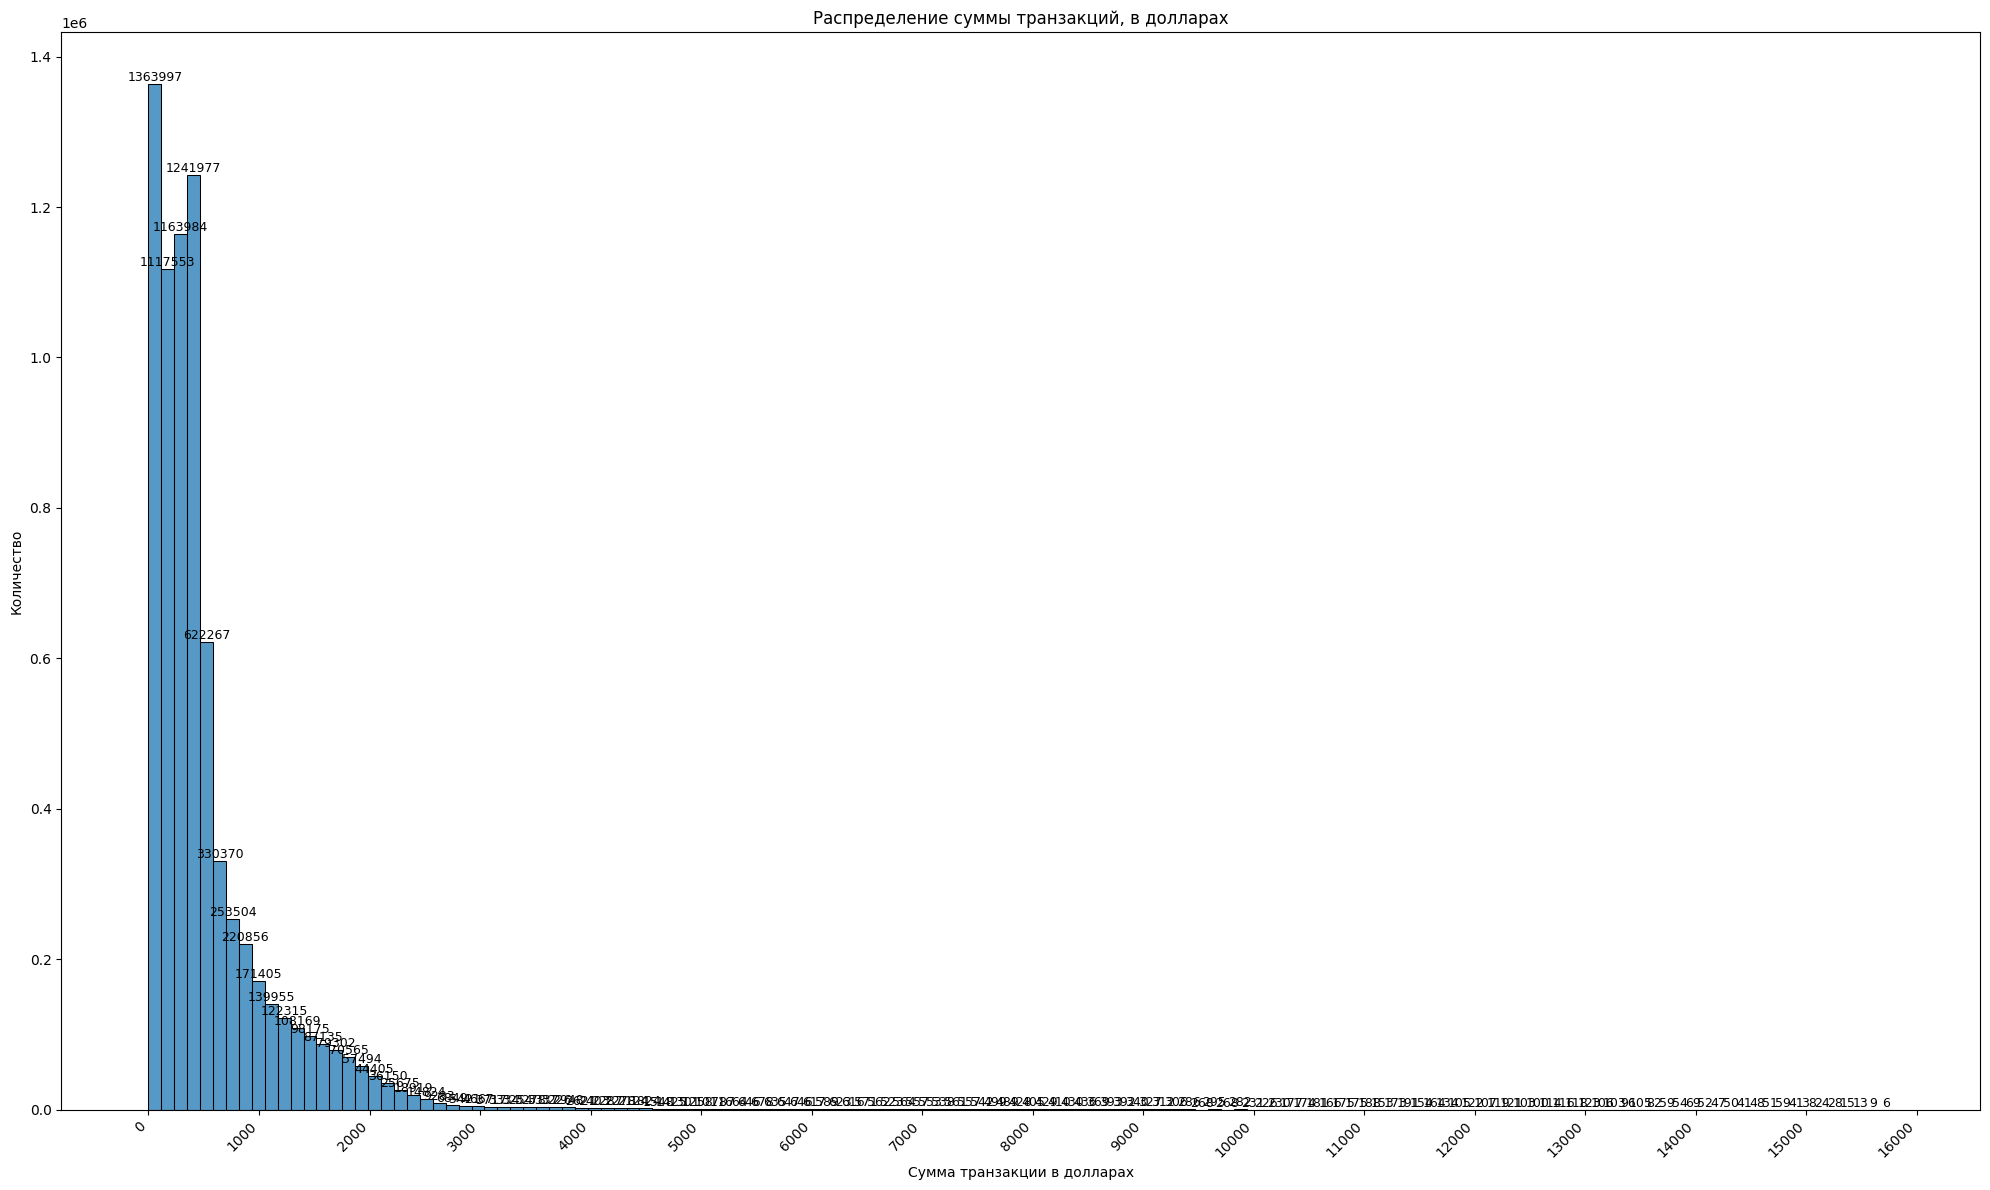

In [20]:
# для количественных признаков

# fig = px.histogram(df, x='amount_USD', nbins=80, title=f"Распределение суммы транзакции в долларах")
# fig.show()


plt.figure(figsize=(20, 7))

# Создаем гистограмму с помощью seaborn
ax = sns.histplot(data=df, x='amount_USD', bins=135)
# Добавляем значения над столбцами
for p in ax.patches:
    height = p.get_height()
    if height > 0: # чтобы не отображать 0
        ax.text(p.get_x() + p.get_width() / 2., height,
                '{:.0f}'.format(height), #Форматируем как целое число
                ha="center", va='bottom', fontsize=9)
plt.xlabel("Сумма транзакции в долларах")
plt.ylabel("Количество")
plt.title('Распределение суммы транзакций, в долларах')

ax.locator_params(axis='x', nbins=30)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()  # Улучшаем расположение элементов графика
plt.show()


In [21]:
df['amount_USD'].median(),df['amount_USD'].min(),df['amount_USD'].max()

(359.26, 0.002406184937605866, 15781.540992547025)

- Большая часть суммы транзакций сосредоточена в промежутке 100-500 долларов
- Имеются выбросы: сильно высокие суммы транзаций (распределение с длинным хвостом)
- Медиана суммы транзакций равна 359.26 долларов

In [14]:
df['date'].min(),df['date'].max()   # данные за месяц, с 30 сентября 2024 по 30 октября 2024

(Timestamp('2024-09-30 00:00:00'), Timestamp('2024-10-30 00:00:00'))

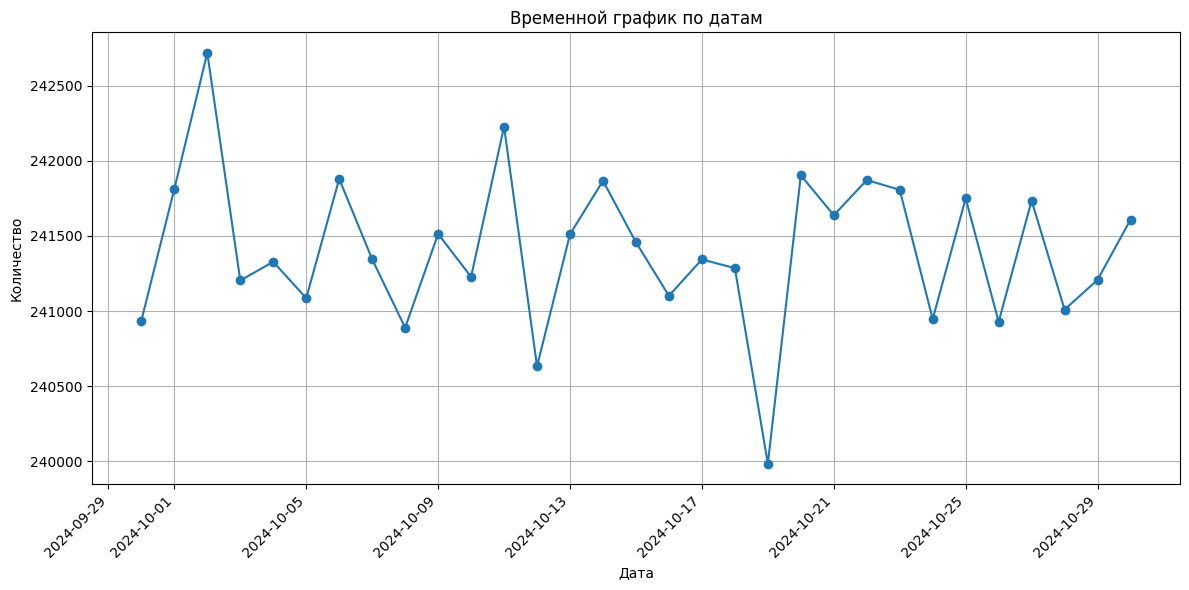

In [20]:
# распределение времени
date_counts = df.groupby('date').size()
plt.figure(figsize=(12, 6))
plt.plot(date_counts.index, date_counts.values, marker='o', linestyle='-')  # Используем
plt.xlabel("Дата")
plt.ylabel("Количество")
plt.title('Временной график по датам')
plt.xticks(rotation=45, ha='right')
plt.tight_layout() #Улучшает расположение элементов графика, чтобы избежать перекрытий
plt.grid()
plt.show()

In [31]:
df['date'].value_counts()

,count
date,
2024-10-02,242718
2024-10-11,242228
2024-10-20,241904
2024-10-06,241880
2024-10-22,241872
2024-10-14,241867
2024-10-01,241813
2024-10-23,241807
2024-10-25,241750


>  
- Анализируемый период: 30 сентября 2024 - 30 октября 2024 (1 месяц)
- В этот период активность была каждый день, не было дней без транзакций
- Больше всего транзакций пришлось на 2 октября
- Меньше всего транзакций было сделано 19 октября



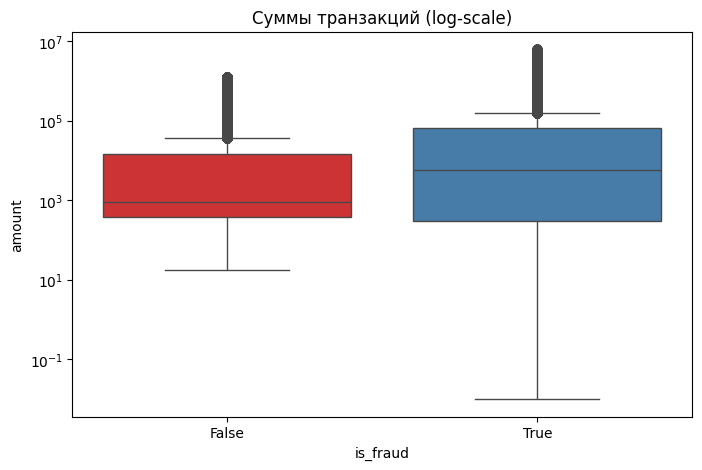

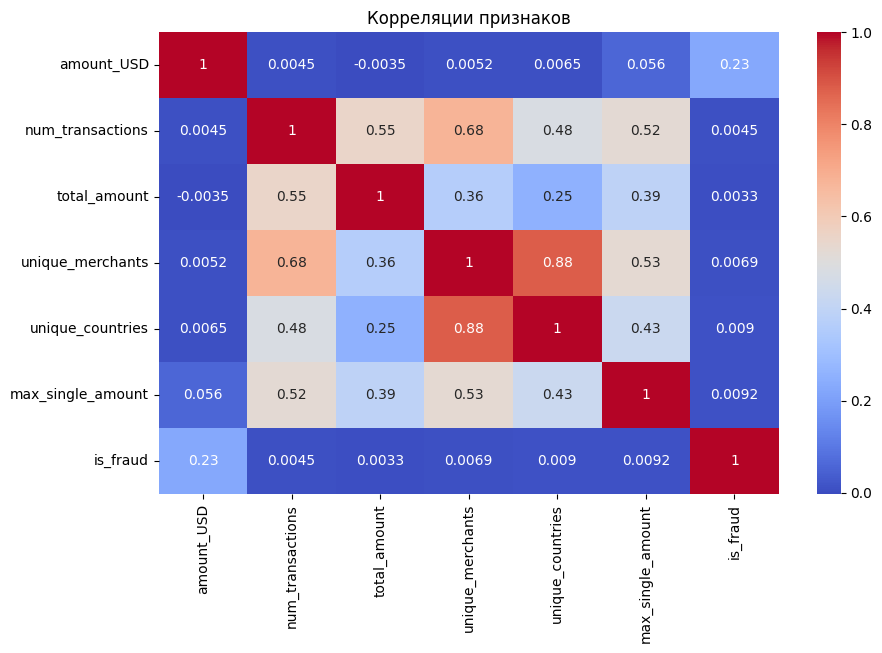

In [19]:
plt.figure(figsize=(8,5))
sns.boxplot(data=df, x='is_fraud', y='amount', palette='Set1')
plt.yscale("log")  # лог-масштаб для длинного хвоста
plt.title("Суммы транзакций (log-scale)")
plt.show()

plt.figure(figsize=(10,6))
sns.heatmap(df[['amount_USD','num_transactions','total_amount','unique_merchants','unique_countries','max_single_amount','is_fraud']].corr(), annot=True, cmap='coolwarm')
plt.title("Корреляции признаков")
plt.show()


> Мошеннические транзакции часто происходят на меньшие суммы и реже на крупные,при этом выбросы присутствуют


### Зависимость в разрезе ```is_fraud```

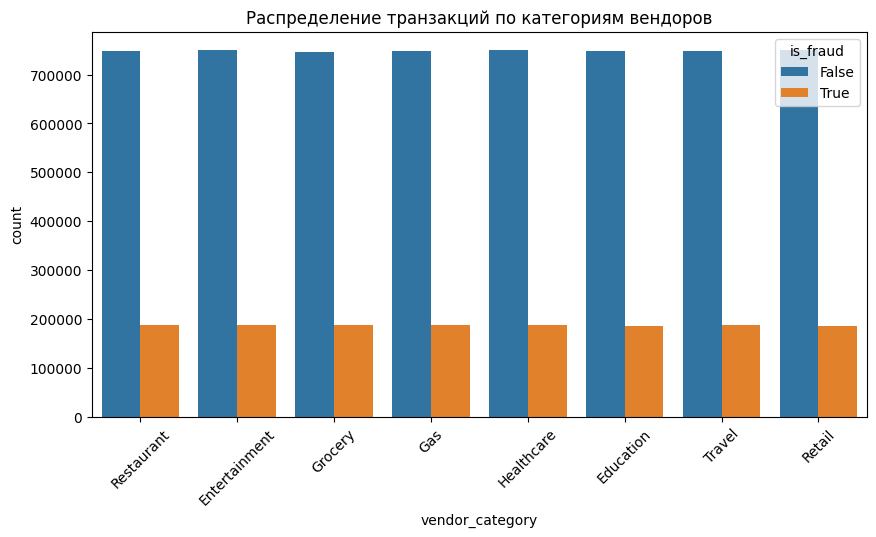

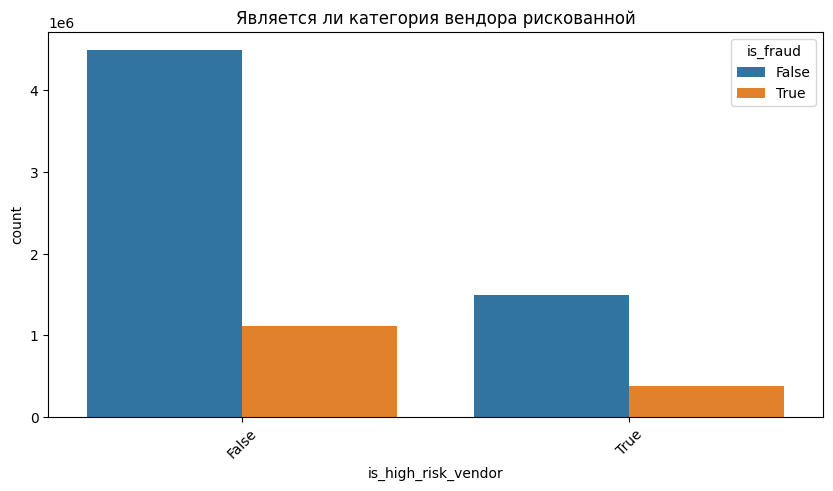

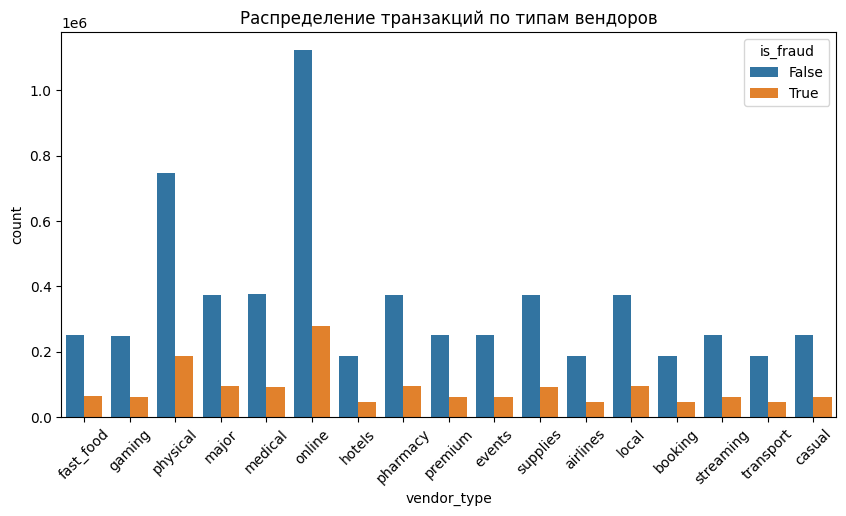

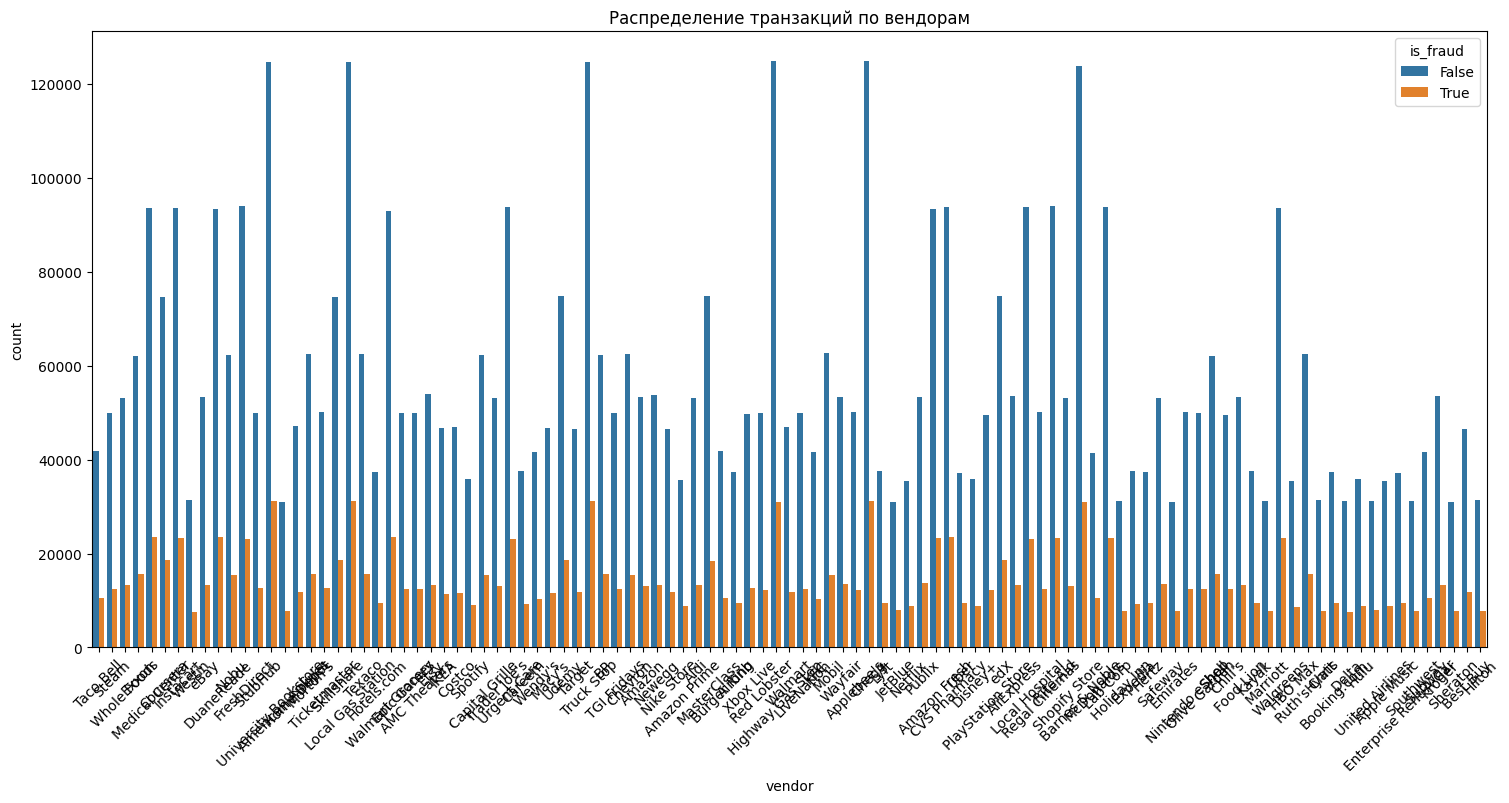

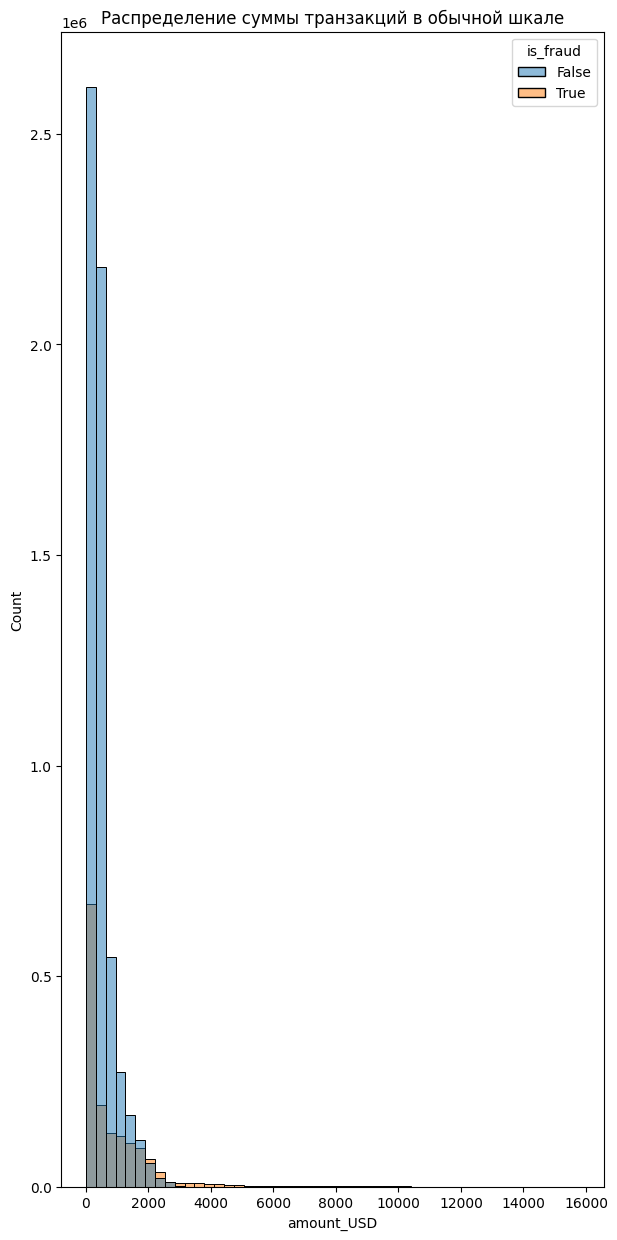

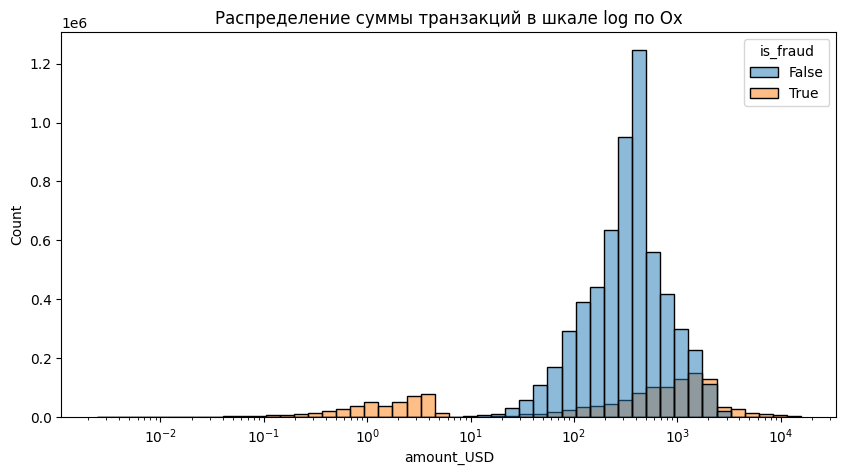

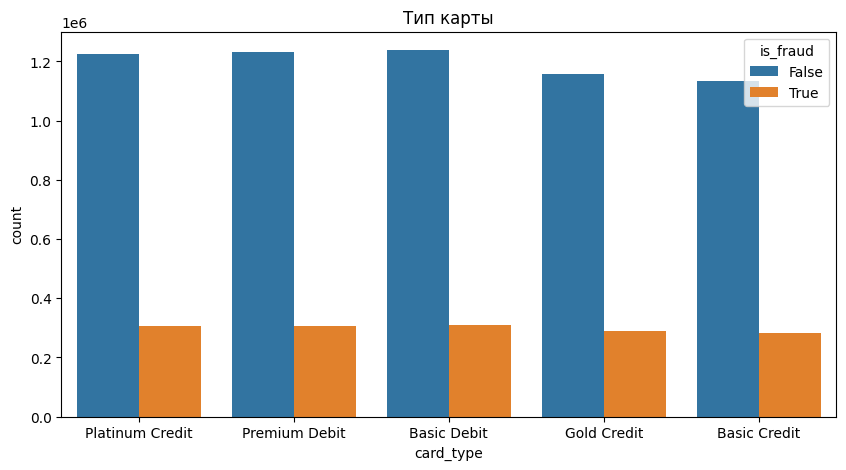

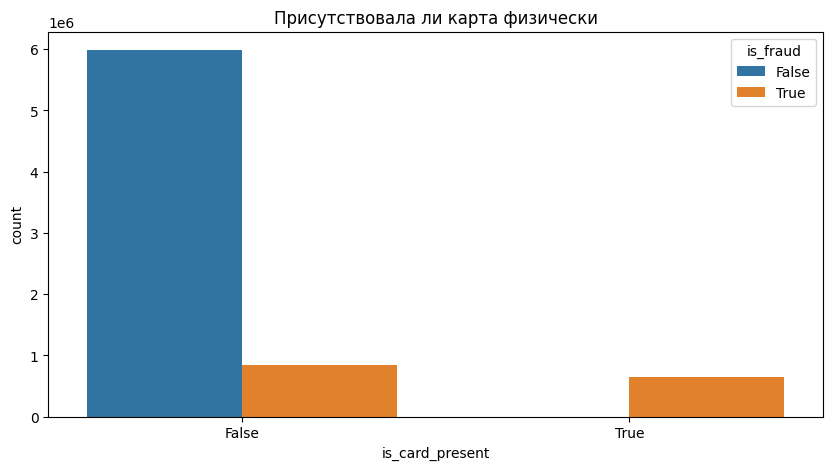

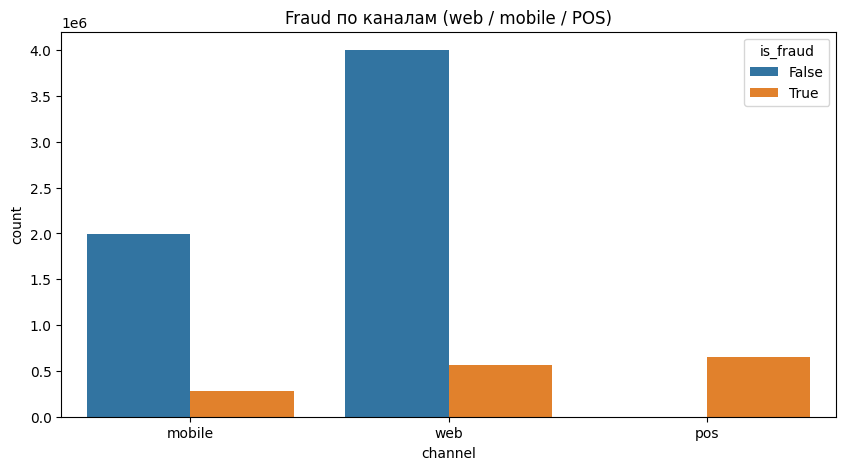

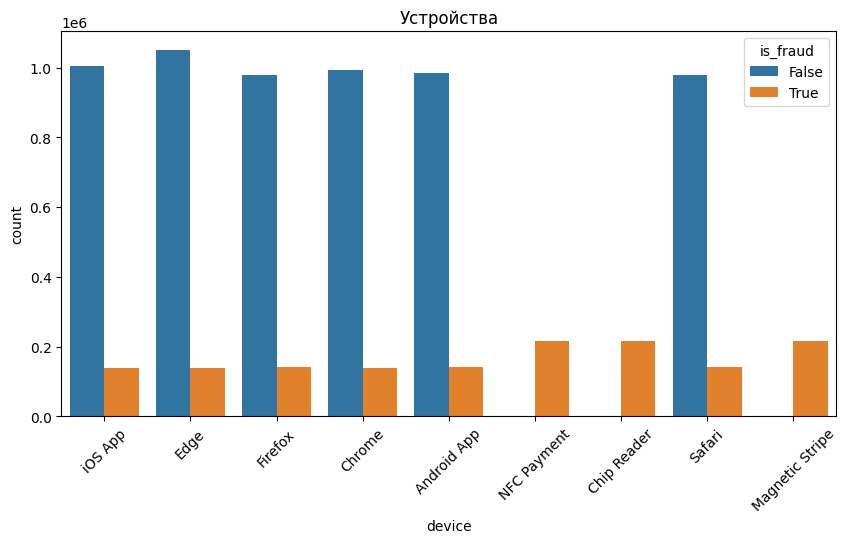

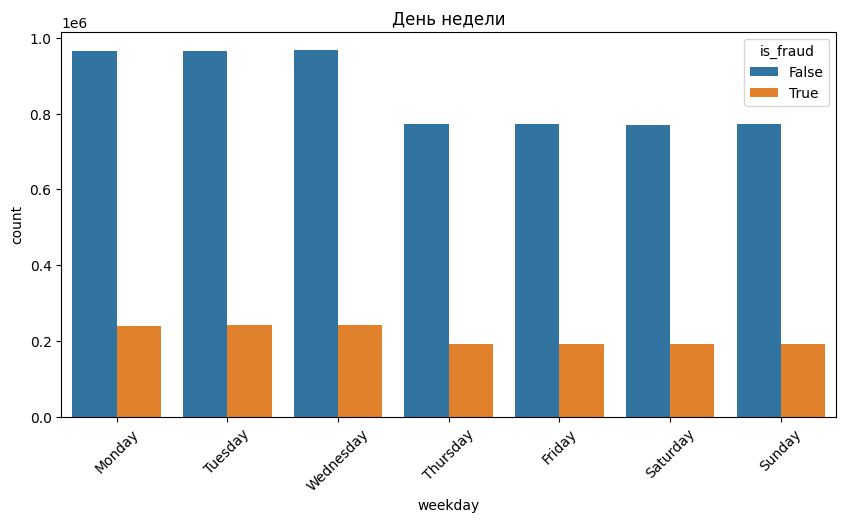

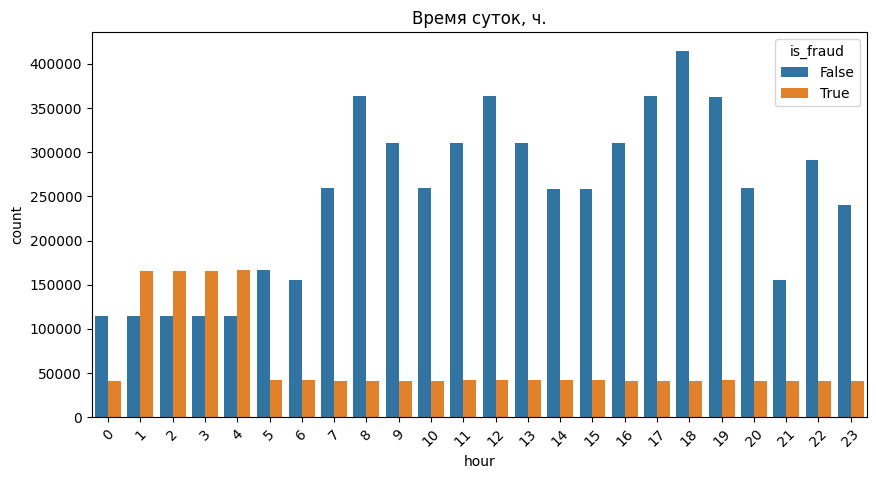

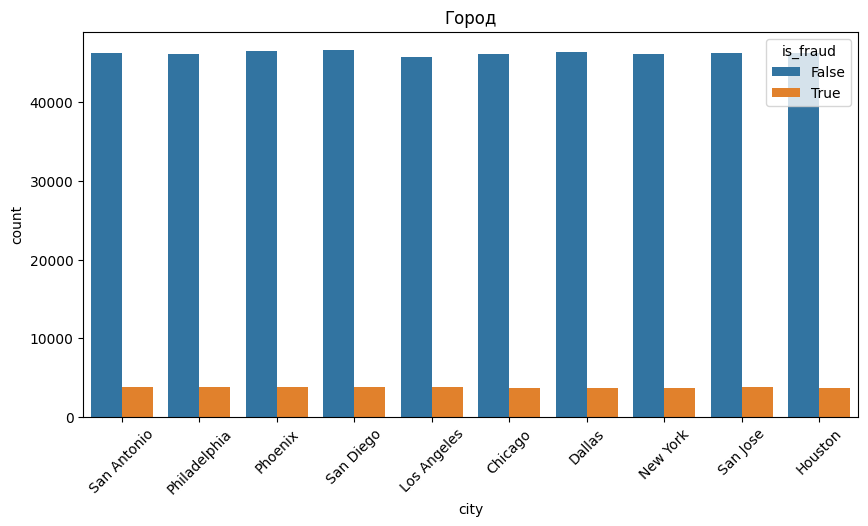

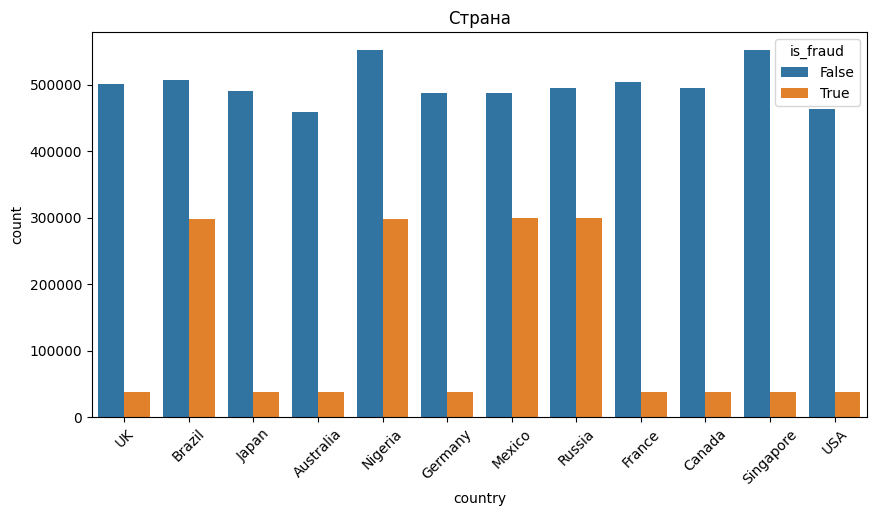

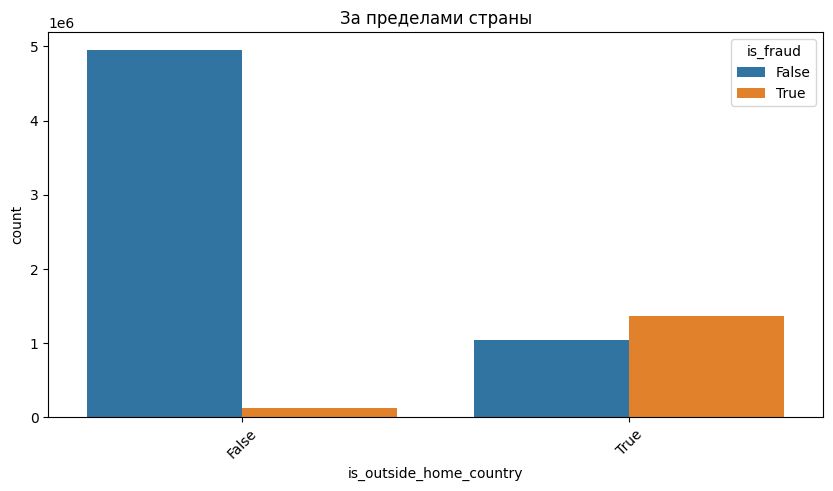

In [96]:
# категории вендоров
plt.figure(figsize=(10,5))
sns.countplot(data=df, x="vendor_category", hue="is_fraud")
plt.xticks(rotation=45)
plt.title("Распределение транзакций по категориям вендоров")
plt.show()

# является ли категория вендора рискованной
plt.figure(figsize=(10,5))
sns.countplot(data=df, x="is_high_risk_vendor", hue="is_fraud")
plt.xticks(rotation=45)
plt.title("Является ли категория вендора рискованной")
plt.show()


# тип вендоров
plt.figure(figsize=(10,5))
sns.countplot(data=df, x="vendor_type", hue="is_fraud")
plt.xticks(rotation=45)
plt.title("Распределение транзакций по типам вендоров")
plt.show()

# вендор
plt.figure(figsize=(18,8))
sns.countplot(data=df, x="vendor", hue="is_fraud")
plt.xticks(rotation=45)
plt.title("Распределение транзакций по вендорам")
plt.show()


# сумма транзакций
plt.figure(figsize=(7,15))
sns.histplot(data=df, x="amount_USD", hue="is_fraud", bins=50, log_scale=(False, False), kde=False)
plt.title("Распределение суммы транзакций в обычной шкале")
plt.show()

# сумма транзакций
plt.figure(figsize=(10,5))
sns.histplot(data=df, x="amount_USD", hue="is_fraud", bins=50, log_scale=(True, False), kde=False)
plt.title("Распределение суммы транзакций в шкале log по Ox")
plt.show()

# тип карты
plt.figure(figsize=(10,5))
sns.countplot(data=df, x="card_type", hue="is_fraud")
plt.title("Тип карты")
plt.show()

# присутствовала ли карта физически
plt.figure(figsize=(10,5))
sns.countplot(data=df, x="is_card_present", hue="is_fraud")
plt.title("Присутствовала ли карта физически")
plt.show()


# каналы
plt.figure(figsize=(10,5))
sns.countplot(data=df, x="channel", hue="is_fraud")
plt.title("Fraud по каналам (web / mobile / POS)")
plt.show()

# устройства
plt.figure(figsize=(10,5))
sns.countplot(data=df, x="device", hue="is_fraud")
plt.xticks(rotation=45)
plt.title("Устройства")
plt.show()

# день недели/выходные
plt.figure(figsize=(10,5))
sns.countplot(data=df, x="weekday", hue="is_fraud")
plt.xticks(rotation=45)
plt.title("День недели")
plt.show()

# время суток
plt.figure(figsize=(10,5))
sns.countplot(data=df, x="hour", hue="is_fraud")
plt.xticks(rotation=45)
plt.title("Время суток, ч.")
plt.show()


# город
plt.figure(figsize=(10,5))
sns.countplot(data=df[df['city']!='Unknown City'], x="city", hue="is_fraud")
plt.xticks(rotation=45)
plt.title("Город")
plt.show()

# страна
plt.figure(figsize=(10,5))
sns.countplot(data=df, x="country", hue="is_fraud")
plt.xticks(rotation=45)
plt.title("Страна")
plt.show()


# за пределами страны
plt.figure(figsize=(10,5))
sns.countplot(data=df, x="is_outside_home_country", hue="is_fraud")
plt.xticks(rotation=45)
plt.title("За пределами страны")
plt.show()


>
- Относительная доля мошеннических транзакций внутри каждой категории выглядит примерно одинаковой. Это означает, что нет явной категории, где мошенничество встречается значительно чаще, чем в других
- Если операция совершена с одного из устройств ```Chip Reader```, ```Magnetic Stripe``` и ```NFC Payment```, она является мошеннической. Легитимные операции не проводятся с этих устройств
- В 100% случаев операции совершенные с канала ```POS``` - мошеннические
- Мошеннические транзакции чаще проводятся ночью в период с ```1``` до ```5``` утра
- Мошенники активно используют мелкие платежи - большая часть мошеннических операций на сумму от ``` ``` до ``` ```
- Все операции суммы, большие чем ``` ```являются мошенническими
- Большая часть мошеннических операций операция проведена вне страны клиента
- Если карта присутсвовала физически, то операция мошенническая

In [4]:
# примержим население стран
response = requests.get('https://ru.wikipedia.org/wiki/Список_государств_и_зависимых_территорий_по_населению')
popularity = pd.read_html(response.content)[0]
popularity['Государство или зависимая территория (от кого зависит)'] = popularity['Государство или зависимая территория (от кого зависит)'].str.replace(r'\[Комм.\s\d+\]', '',regex = True)
popularity.rename(columns = {'Государство или зависимая территория (от кого зависит)': 'country'}, inplace = True)
display(popularity.head(3))
popularity.shape, popularity['country'].nunique()

,№,country,Население,Дата,% от населения Земли,Источник
0,1,Индия,1 443 032 000,15 августа 2025,17.54%,Счётчик[1]
1,2,Китай,1 408 280 000,1 января 2024,17.14%,Оценка[2]
2,3,США,341 169 410,1 января 2025,4.06%,Оценка[3]


((242, 6), 242)

In [5]:
df['country_RU'] = df['country'].map({
    "UK" :"Великобритания",
    "Brazil":  "Бразилия",
    "Japan": "Япония",
    "Australia":"Австралия",
    "Nigeria":"Нигерия",
    "Germany":"Германия",
    "Mexico":"Мексика",
    "Russia":"Россия",
    "France":"Франция",
    "Canada":"Канада",
    "Singapore":"Сингапур",
    'USA': 'США'}
)
df = df.merge(
    popularity[['country','Население']].rename(
        columns = {
            'country':'country_RU',
            'Население': 'population'
        }
    ), 'left', on = 'country_RU'
)

symbol = df['population'].str.strip().iloc[0][2]
df['population'] = df['population'].str.strip().str.replace(symbol,'').astype(int)

In [6]:
df['population'].isna().sum()

np.int64(0)

In [43]:
fraud = df[df['is_fraud']]
fraud.shape

(1494719, 35)

In [50]:
fraud_country_group = pd.DataFrame(fraud.groupby(['country','population']).agg({'transaction_id': 'count',
                                                                                'amount_USD':'sum'   # сумма сумм мошеннических транзакций
                                                                                })\
.reset_index(drop = False).rename(columns = {'transaction_id':'fraud_count', 'amount_USD': 'amount_total'}))
fraud_country_group.head(4)

,country,population,fraud_count,amount_total
0,Australia,26966789,37652,3.882505e+07
1,Brazil,203080756,298629,3.007545e+08
2,Canada,41012563,37278,3.864555e+07
3,France,66150000,37426,3.955923e+07


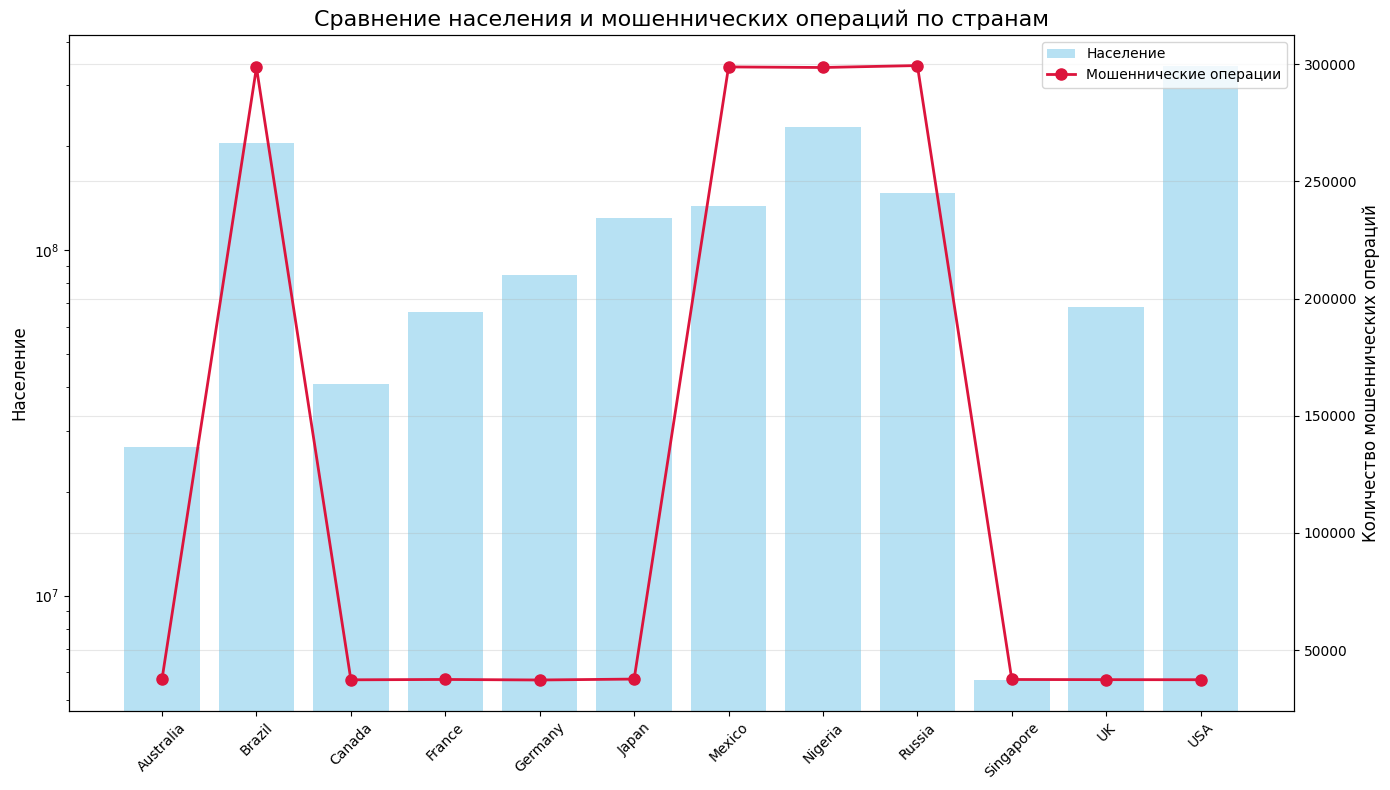

In [51]:
# Сортировка по населению
country_stats = fraud_country_group.sort_values('population', ascending=False)

fig, ax1 = plt.subplots(figsize=(14, 8))

# Столбцы для населения
ax1.bar(
    fraud_country_group['country'],
    fraud_country_group['population'],
    color='skyblue',
    alpha=0.6,
    label='Население'
)
ax1.set_ylabel('Население', fontsize=12)
ax1.tick_params(axis='x', rotation=45)
ax1.set_yscale('log')  # Логарифмическая шкала из-за большого разброса

# Вторая ось для мошенничеств
ax2 = ax1.twinx()
ax2.plot(
    fraud_country_group['country'],
    fraud_country_group['fraud_count'],
    'o-',
    color='crimson',
    markersize=8,
    linewidth=2,
    label='Мошеннические операции'
)
ax2.set_ylabel('Количество мошеннических операций', fontsize=12)

# Объединение легенд
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper right')

plt.title('Сравнение населения и мошеннических операций по странам', fontsize=16)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig('population_fraud_comparison.png', dpi=300)
plt.show()

>  Прямой корреляции между населением страны и количеством мошеннических операций в стране не наблюдается

In [3]:
# Кол-во транзакций и fraud по странам
country_stats = (
    df.groupby("country")["is_fraud"]
    .agg(["count", "mean"])
    .reset_index()
    .rename(columns={"count": "num_transactions", "mean": "fraud_rate"})
)

# Тепловая карта: fraud_rate
fig = px.choropleth(
    country_stats,
    locations="country",
    locationmode="country names",
    color="fraud_rate",
    hover_name="country",
    hover_data=["num_transactions"],
    color_continuous_scale="Reds",
    title="Fraud Rate by Country"
)
fig.show()

>
- Географическое распределение мошенничества неравномерно
- Россия, Нигерия, Бразилия и Мексика являются основными точками мошеннической активности
- Развитые страны (США, Канада, Австралия) имеют средний уровень мошенничества
- В большинстве стран уровень мошенничества низкий или отсутствует

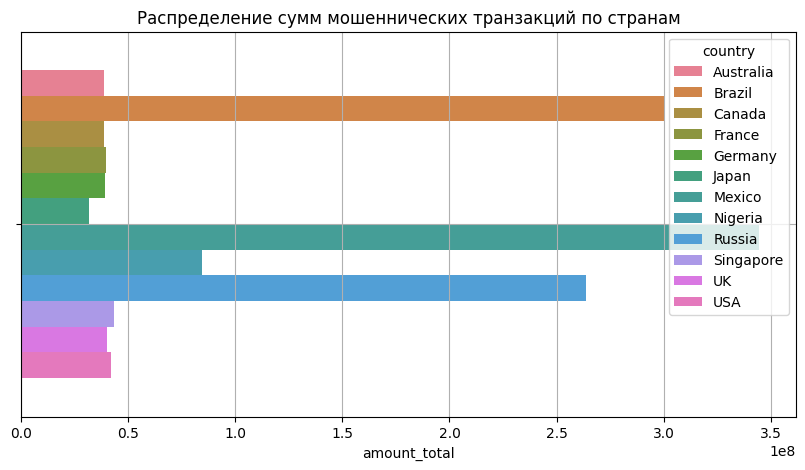

In [76]:
# сумма мошеннических транзакций по странам
plt.figure(figsize=(10,5))
sns.barplot(data=fraud_country_group, x="amount_total", hue="country")
plt.title("Распределение сумм мошеннических транзакций по странам")
plt.grid()
plt.show()

- В Нигрерии и Бразилии осуществляются мошеннические транзакции на самые большие суммы

In [7]:
df['customer_id'].nunique()

4869

In [5]:
# Разделение данных на мошеннические и легитимные операции
fraud_df = df[df['is_fraud']]
legit_df = df[~df['is_fraud']]

# Агрегация по дням
daily_fraud = fraud_df.groupby('date').size().reset_index(name='fraud_count')
daily_legit = legit_df.groupby('date').size().reset_index(name='legit_count')

# Объединение данных
daily_data = pd.merge(daily_fraud, daily_legit, on='date', how='outer').fillna(0)
daily_data.head(3)

,date,fraud_count,legit_count
0,2024-09-30,47880,193057
1,2024-10-01,48342,193471
2,2024-10-02,48382,194336


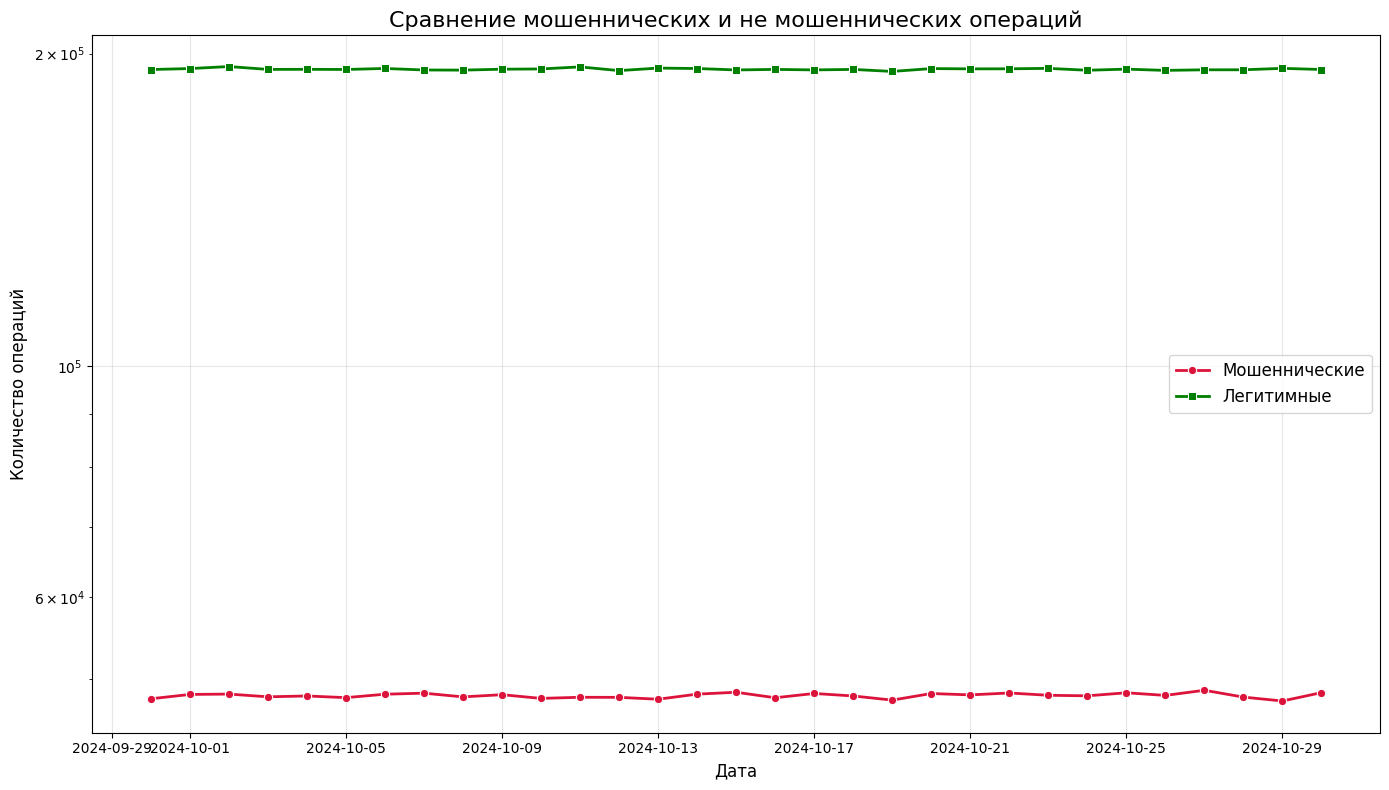

In [6]:
plt.figure(figsize=(14, 8))

ax = sns.lineplot(
    x='date',
    y='fraud_count',
    data=daily_data,
    color='crimson',
    linewidth=2,
    marker='o',
    markersize=6,
    label='Мошеннические'
)

sns.lineplot(
    x='date',
    y='legit_count',
    data=daily_data,
    color='green',
    linewidth=2,
    marker='s',
    markersize=6,
    label='Легитимные',
    ax=ax
)

plt.title('Сравнение мошеннических и не мошеннических операций', fontsize=16)
plt.xlabel('Дата', fontsize=12)
plt.ylabel('Количество операций', fontsize=12)
plt.grid(alpha=0.3)
plt.legend(fontsize=12)
plt.yscale('log')  # Логарифмическая шкала для наглядности различий

plt.tight_layout()
plt.show()

> График показывает стабильный уровень мошеннических операций на протяжении всего периода. Отсутствие выраженных трендов или колебаний говорит о том, что в этот период не было каких-либо значительных изменений в характере мошеннической активности

In [ ]:
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    return np.sqrt(phi2 / min((k-1), (r-1)))


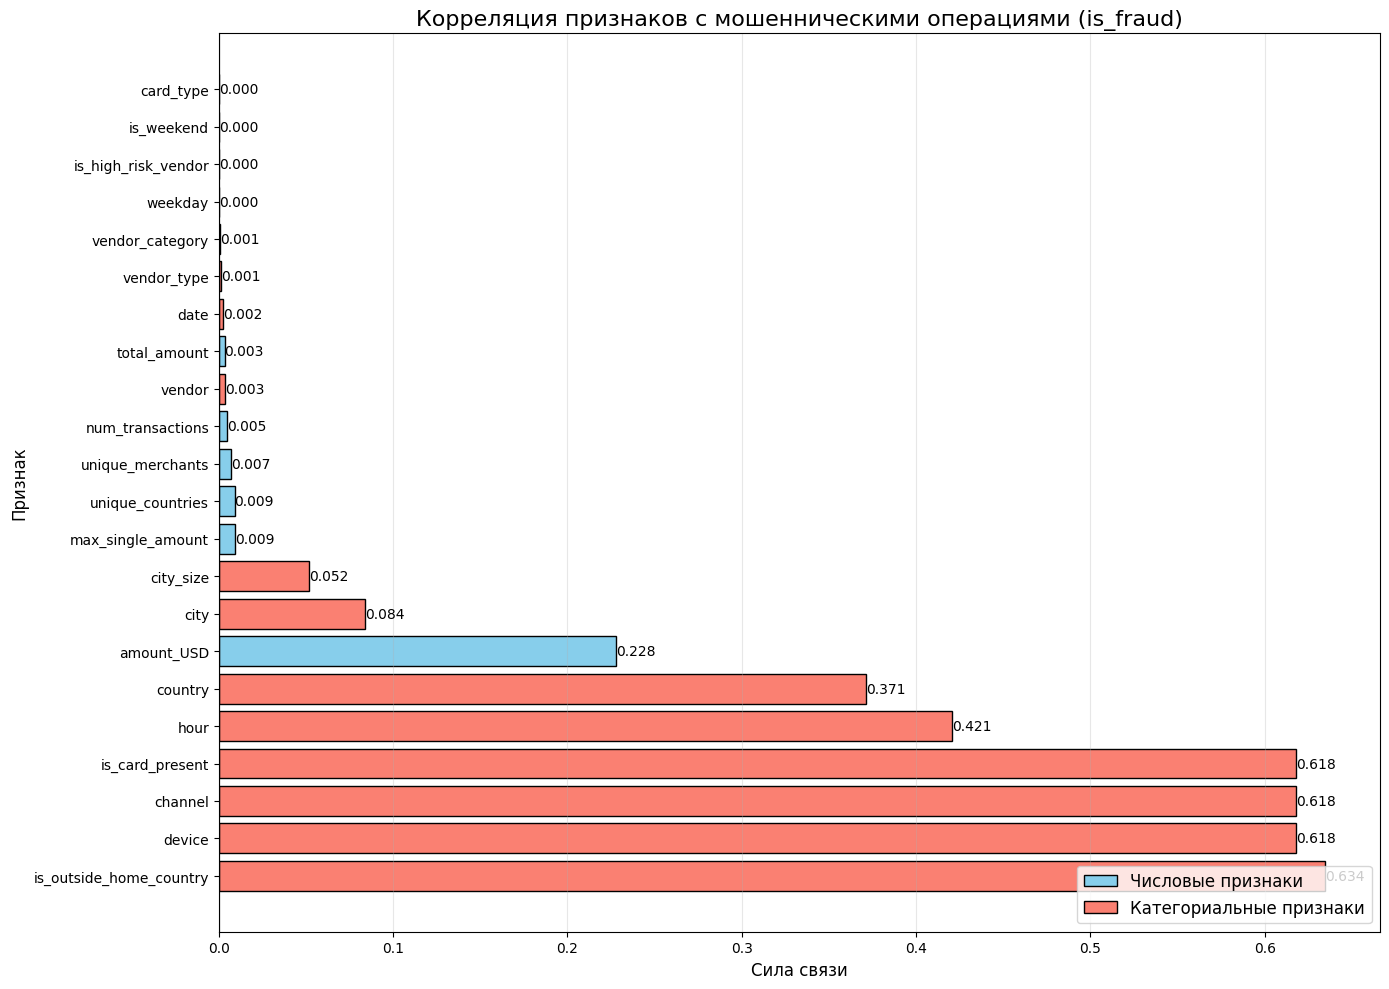

In [14]:
# корреляция между is_fraud и остальными признаками

# признаки
features = df.drop(columns = ['transaction_id', 'customer_id', 'card_number', 'timestamp','amount', 'currency','device_fingerprint', 'ip_address', 'value', 'value_USD','is_fraud']).columns

correlations = {}
# корреляция для каждого признака
for feature in features:
    if df[feature].dtype in ['int64', 'float64']:
        # Для числовых признаков: точечно-бисериальная корреляция
        corr, _ = pointbiserialr(df[feature], df['is_fraud'])
        correlations[feature] = corr
    else:
        # Для категориальных: Cramér's V
        correlations[feature] = cramers_v(df[feature], df['is_fraud'])

# Создаем DataFrame для визуализации
corr_df = pd.DataFrame({
    'feature': list(correlations.keys()),
    'correlation': list(correlations.values()),
    'type': ['numeric' if df[f].dtype in ['int64','float64'] else 'categorical' for f in correlations.keys()]
})

# Сортируем по абсолютному значению корреляции
corr_df['abs_corr'] = np.abs(corr_df['correlation'])
corr_df = corr_df.sort_values('abs_corr', ascending=False)

# Визуализация
plt.figure(figsize=(14, 10))
colors = corr_df['type'].map({'numeric': 'skyblue', 'categorical': 'salmon'})

# Барплот
bars = plt.barh(
    corr_df['feature'],
    corr_df['correlation'],
    color=colors,
    edgecolor='black'
)
# добавляем значения
for bar in bars:
    width = bar.get_width()
    plt.text(width if width > 0 else width - 0.02,
             bar.get_y() + bar.get_height()/2,
             f'{width:.3f}',
             va='center',
             fontsize=10)

plt.title('Корреляция признаков с мошенническими операциями (is_fraud)', fontsize=16)
plt.xlabel('Сила связи', fontsize=12)
plt.ylabel('Признак', fontsize=12)
plt.axvline(0, color='black', linewidth=0.8)
plt.grid(axis='x', alpha=0.3)


legend_elements = [
    Patch(facecolor='skyblue', edgecolor='black', label='Числовые признаки'),
    Patch(facecolor='salmon', edgecolor='black', label='Категориальные признаки')
]
plt.legend(handles=legend_elements, loc='lower right', fontsize=12)

plt.tight_layout()
plt.show()

>
- От категориальных переменных зависимость сильнее
- Наиболее сильную корреляцию с мошенническими операциями (is_fraud) показывают следующие категориальные признаки:

      * is_outside_home_country (0.634): Операция проведена вне страны клиента.
      * device (0.618): Устройство, с которого проведена транзакция
      * channel (0.618): Канал проведения транзакции (веб, мобильный, POS)
      * is_card_present (0.618): Присутствовала ли карта физически при оплате
      * hour (0.421): Час совершения транзакции
      * country (0.371): Страна, где совершена транзакция.
- Ключевыми факторами являются признаки, связанные с местоположением, временем, устройством и каналом проведения транзакции. Сумма транзакции также важна, но в меньшей степени

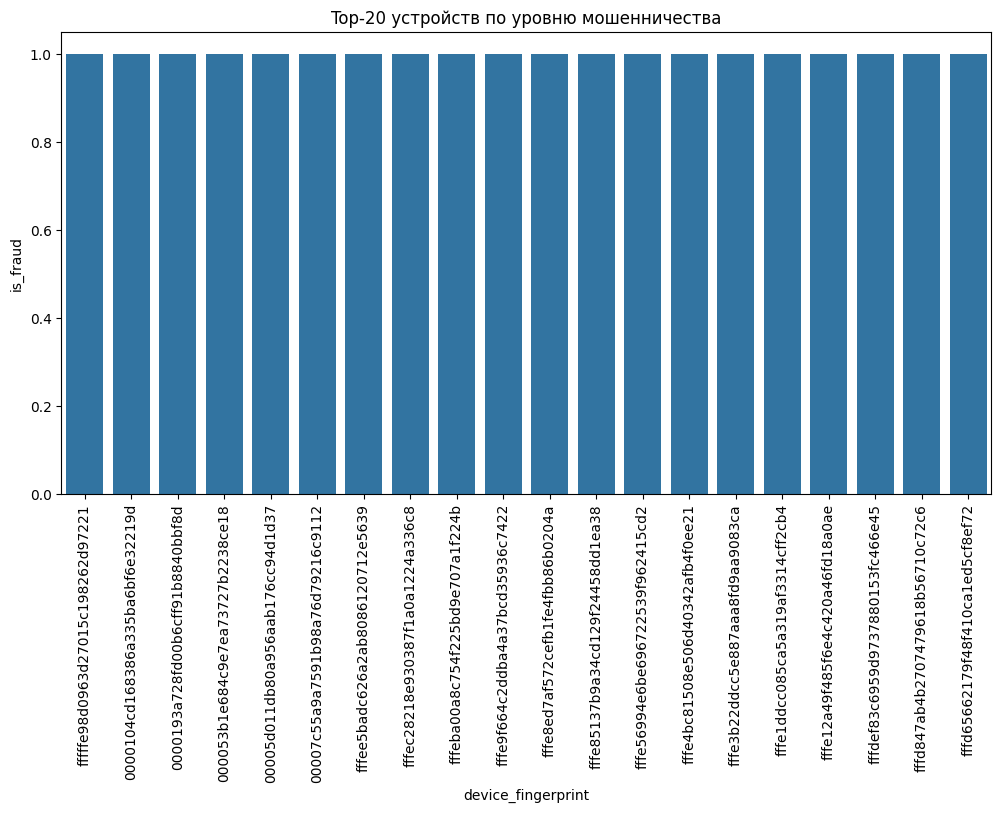

In [5]:
# Количество клиентов на одно устройство
device_fraud = df.groupby("device_fingerprint")["is_fraud"].mean().reset_index()
device_fraud = device_fraud.sort_values("is_fraud", ascending=False).head(20)

plt.figure(figsize=(12,6))
sns.barplot(data=device_fraud, x="device_fingerprint", y="is_fraud")
plt.xticks(rotation=90)
plt.title("Top-20 устройств по уровню мошенничества")
plt.show()


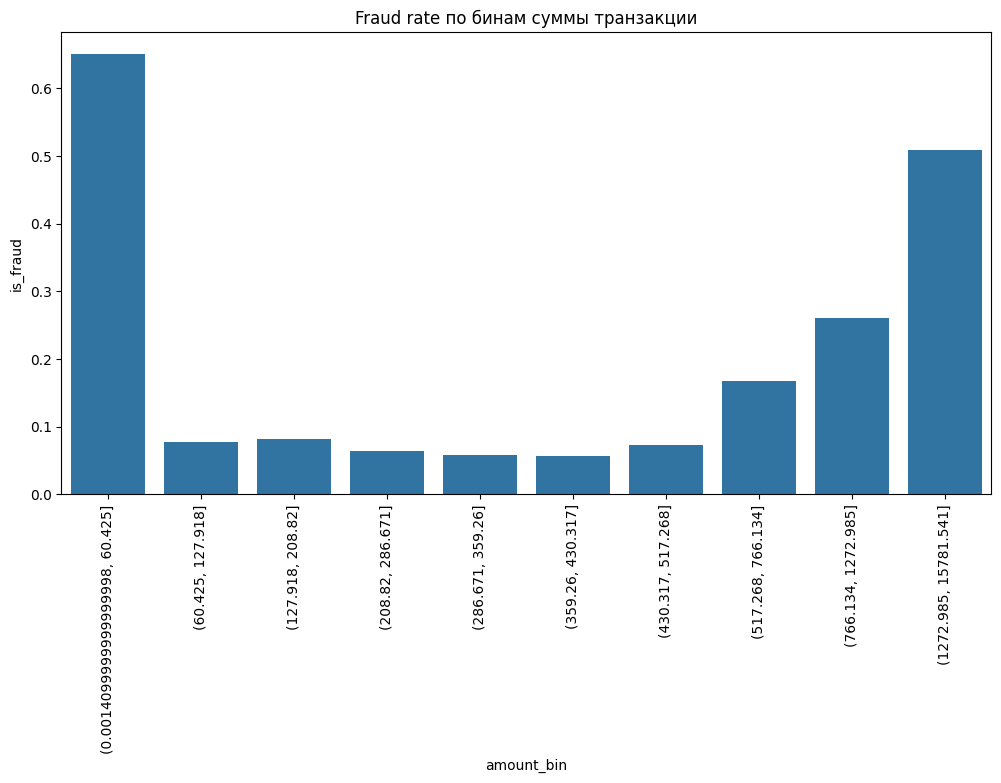

In [6]:
# Биннинг сумм
df['amount_bin'] = pd.qcut(df['amount_USD'], q=10, duplicates='drop')

fraud_by_amount = df.groupby("amount_bin")["is_fraud"].mean().reset_index()

plt.figure(figsize=(12,6))
sns.barplot(data=fraud_by_amount, x="amount_bin", y="is_fraud")
plt.xticks(rotation=90)
plt.title("Fraud rate по бинам суммы транзакции")
plt.show()


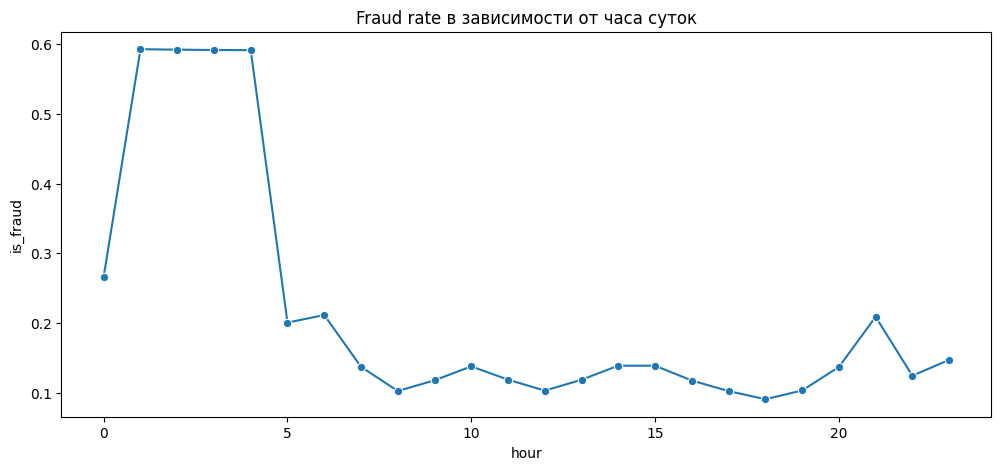

In [18]:
plt.figure(figsize=(12,5))
sns.lineplot(data=df, x="hour", y="is_fraud", estimator="mean", ci=None, marker="o")
plt.title("Fraud rate в зависимости от часа суток")
plt.show()


>


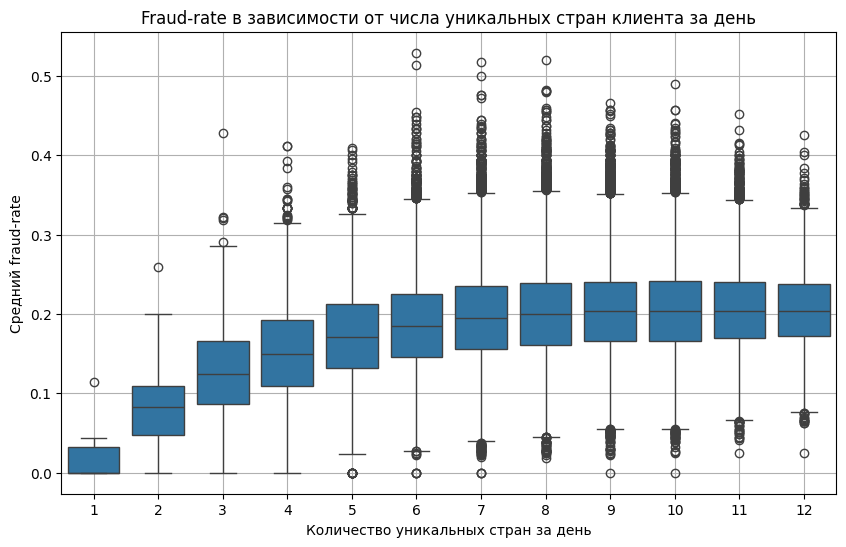

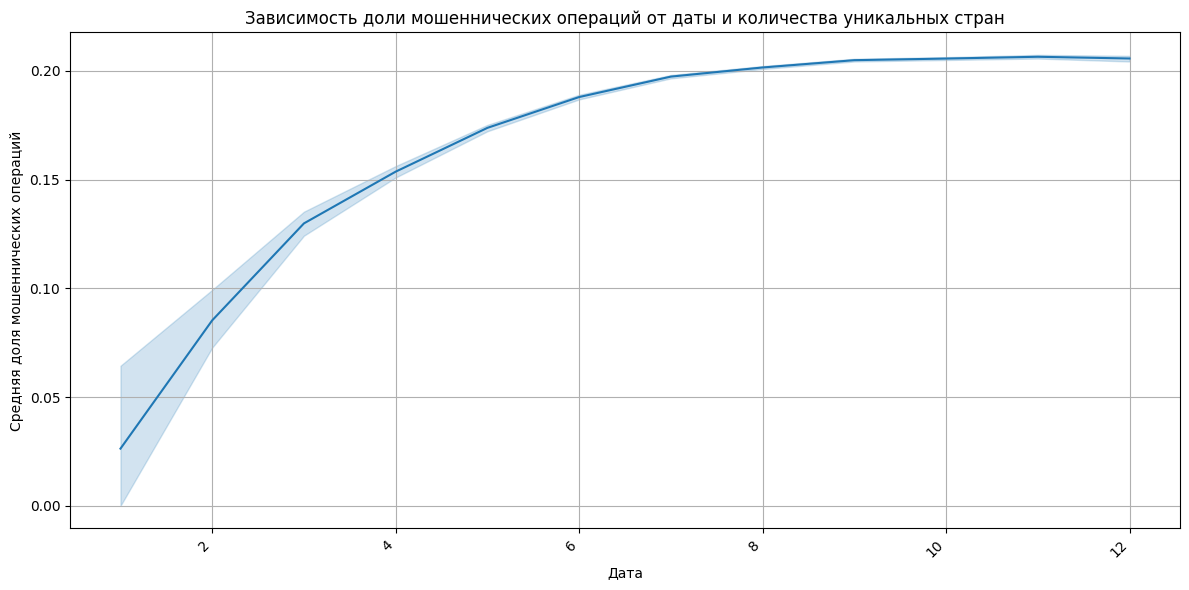

In [17]:
df_grouped = pd.DataFrame(df.groupby(['customer_id','date']).agg({'country':'nunique','is_fraud': 'mean'})).reset_index(drop = False)
# График зависимости fraud rate от числа уникальных стран
plt.figure(figsize=(10,6))
sns.boxplot(data=df_grouped, x="country", y="is_fraud")
plt.title("Fraud-rate в зависимости от числа уникальных стран клиента за день")
plt.xlabel("Количество уникальных стран за день")
plt.ylabel("Средний fraud-rate")
plt.grid()
plt.show()

plt.figure(figsize=(12, 6))
sns.lineplot(data=df_grouped, x='country', y='is_fraud', palette='viridis')
plt.xlabel("Дата")
plt.ylabel("Средняя доля мошеннических операций")
plt.title("Зависимость доли мошеннических операций от даты и количества уникальных стран")
plt.xticks(rotation=45, ha='right')
plt.grid()
plt.tight_layout()

> Если пользовтаель за один день совершал транзакции из разных стран, с увечлиением числа уникальных стран за день вероятность фрода растет

In [21]:
df.groupby('country')['currency'].unique().sort_values()   # в одной стране одна валюта

,currency
country,
Australia,[AUD]
Brazil,[BRL]
Canada,[CAD]
France,[EUR]
Germany,[EUR]
UK,[GBP]
Japan,[JPY]
Mexico,[MXN]
Nigeria,[NGN]


> В каждой стране используются собственные валюты для проведения транзакций -> мошенники не используют другие валюты для проведения операций